<h1>Detect and extract players</h1>
<p> Detect players using pre-trained yolo network and extract them using Mask-RCNN</p>

In [25]:
import numpy as np
import argparse
import random
import time
import cv2
import os

In [26]:
RED_COLOR = np.array([255, 0, 0]) 
BLACK_COLOR = np.array([255, 255, 255]) 

<p>Load weights and Mask-RCNN configuration</p>

In [27]:
weightsPath = "network_configuration/frozen_inference_graph.pb"
configPath = "network_configuration/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)

[INFO] image size: 640x360 pixels


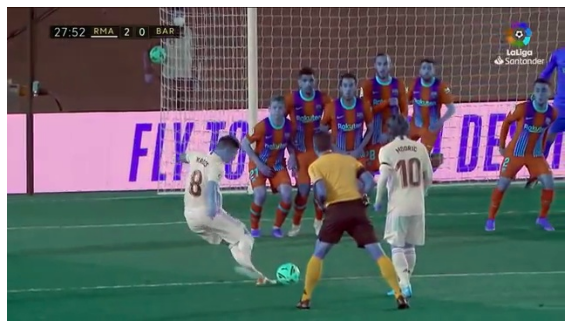

In [28]:
# load our input image and grab its spatial dimensions
image = cv2.imread('./Images/Highlights Real Madrid vs FC Barcelona (2-1)/frame24.jpg', cv2.IMREAD_UNCHANGED)
(H, W) = image.shape[:2]
print("[INFO] image size: {}x{} pixels".format(W, H))
from matplotlib import pyplot as plt
plt.figure(figsize=(10,30))
plt.imshow(image)
plt.axis('off')
plt.show()  

In [29]:
# construct a blob from the input image and then perform a forward
# pass of the Mask R-CNN, giving us (1) the bounding box coordinates
# of the objects in the image along with (2) the pixel-wise segmentation
# for each specific object
blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
(boxes, masks) = net.forward(["detection_out_final", "detection_masks"])
end = time.time()
# show timing information and volume information on Mask R-CNN
print("[INFO] Mask R-CNN took {:.6f} seconds".format(end - start))
print("[INFO] boxes shape: {}".format(boxes.shape))
print("[INFO] boxes size: {}".format(boxes.size))
print("[INFO] masks shape: {}".format(masks.shape))

[INFO] Mask R-CNN took 1.391094 seconds
[INFO] boxes shape: (1, 1, 100, 7)
[INFO] boxes size: 700
[INFO] masks shape: (100, 90, 15, 15)


In [30]:
# create directory to store images
path = os.getcwd() + '/ImagesFromObject'
if not os.path.exists(path):
    os.mkdir(path)

In [77]:
new_image = image

In [83]:
def plot_boxes(new_image):
	# loop over the number of detected objects
	for i in range(0, boxes.shape[2]):
		# extract the class ID of the detection along with the confidence
		# (i.e., probability) associated with the prediction
		classID = int(boxes[0, 0, i, 1])
		confidence = boxes[0, 0, i, 2]

		# filter out weak predictions by ensuring the detected probability
		# is greater than the minimum probability
		if confidence > 0.5:
			box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
			(startX, startY, endX, endY) = box.astype("int")
			boxW = endX - startX
			boxH = endY - startY
			mask = masks[i, classID]
			mask = cv2.resize(mask, (boxW, boxH), interpolation = cv2.INTER_NEAREST)
			mask1 = (mask > 1)
			_, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)

			# extract the ROI of the image
			roi = new_image[startY:endY, startX:endX]
			# now, extract *only* the masked region of the ROI by passing in the boolean mask array as our slice condition
			roi = roi[mask1]

			# Red will be used to visualize this particular instance segmentation 
			# then create a transparent overlay by blending the randomly selected color with the ROI
			blended = ((0.4 * RED_COLOR) + (0.6 * roi)).astype("uint8")

			# store the blended ROI in the original image
			new_image[startY:endY, startX:endX][mask1] = blended

			if (plot_boxes):
				# draw the bounding box of the instance on the image
				cv2.rectangle(new_image, (startX, startY), (endX, endY), (255,255,255), 2)

				# draw the predicted label and associated probability of the instance segmentation on the image
				text = "{}: {:.4f}".format("Person", confidence)
				cv2.putText(new_image, text, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

In [92]:
players = []

In [95]:
def extract_players(image):
    height, width , _ = image.shape
    cv2_img_bb = np.array(image) 
    # Convert RGB to BGR 
    cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB) 
    for i in range(boxes.shape[2]):
        box = boxes[0, 0 ,i]
        class_id = box[1]
        score = box[2]
        if (score < 0.5):
            continue
        # get box coordinates
        x = int(box[3] * width)
        y = int(box[4] * height)
        x2 = int(box[5] * width)
        y2 = int(box[6] * height)

        object_of_image = image[y: y2, x: x2]
        ooi_height, ooi_width, _ = object_of_image.shape

        # get the mask
        mask = masks[i, int(class_id)]
        mask = cv2.resize(mask, (ooi_width, ooi_height))
        _, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)

        # convert mask to proper type in order to perform the bitwise_and
        visMask = (mask * 255).astype("uint8")

        # extract from box only the object for classification
        final = cv2.bitwise_and(object_of_image, object_of_image, mask = visMask)
        players.append(final)
        cv2.imwrite(path + "/person"+str(i)+".jpg", final)
        cv2.rectangle(cv2_img_bb, (x,y), (x2,y2), (255, 0, 0), 3)

In [85]:
plot_boxes_and_extract_objects(new_image)

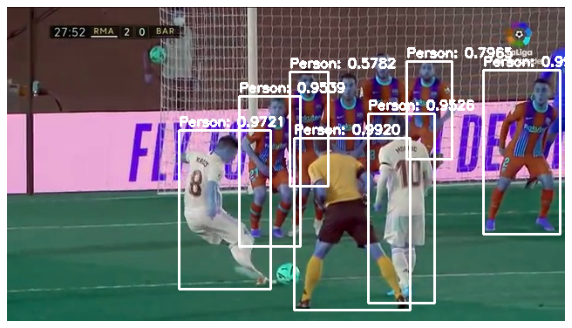

In [86]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,30))
plt.imshow(new_image)
plt.axis('off')
plt.show()  

In [96]:
image = cv2.imread('./Images/Highlights Real Madrid vs FC Barcelona (2-1)/frame24.jpg', cv2.IMREAD_UNCHANGED)
extract_players(image)